In [3]:
#intuitive try:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("Dry_Bean_Dataset.csv")

# Assuming the last column is the label
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Convert labels to integer values
classes = np.unique(y)
y_int = np.array([np.where(classes == label)[0][0] for label in y])

X_train, X_test, y_train, y_test = train_test_split(X, y_int, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create DMatrix, the internal data structure that XGBoost uses
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters for classification
params = {
    'objective': 'multi:softmax',  # for multiclass classification
    'num_class': len(classes),
    'eta': 0.1,
    'max_depth': 4
}
num_round = 20  # number of boosting rounds

# Train the model
bst = xgb.train(params, dtrain, num_round)

# Make predictions
predictions = bst.predict(dtest)
# Make predictions on the training data
train_predictions = bst.predict(dtrain)
print("Train accuracy:", accuracy_score(y_train, train_predictions))
print("Predictions:", predictions)
print("test accuracy:", accuracy_score(y_test, predictions))
print("test data report:", classification_report(y_test, predictions))

Train accuracy: 0.9312480319093104
Predictions: [5. 0. 5. ... 4. 5. 0.]
test accuracy: 0.9204211557296768
test data report:               precision    recall  f1-score   support

           0       0.94      0.88      0.91       395
           1       1.00      1.00      1.00       161
           2       0.92      0.94      0.93       479
           3       0.91      0.92      0.91      1043
           4       0.97      0.94      0.96       588
           5       0.95      0.94      0.94       619
           6       0.85      0.88      0.87       799

    accuracy                           0.92      4084
   macro avg       0.94      0.93      0.93      4084
weighted avg       0.92      0.92      0.92      4084



In [4]:
#using gridsearchcv to find hyperparameters for XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

print("Loading data...")
data = pd.read_csv("Dry_Bean_Dataset.csv")
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
classes = np.unique(y)
y_int = np.array([np.where(classes == label)[0][0] for label in y])

print("Splitting data into train/val/test sets...")
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y_int, test_size=0.3, random_state=42, stratify=y_int)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)


print("Setting up the XGBClassifier and parameter grid...")
clf = XGBClassifier(
    objective='multi:softmax',
    num_class=len(classes),
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1
)

param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [4, 6, 8],
    'n_estimators': [200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1, 5]
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

print("Starting grid search. This may take a while...")
grid = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

fit_params = {
    "eval_set": [(X_val, y_val)],
    "verbose": False
}

grid.fit(X_train, y_train, **fit_params)

print("Best hyperparameters found:")
print(grid.best_params_)
print("Best cross-validation score:", grid.best_score_)

print("Evaluating best model on test set...")
best_model = grid.best_estimator_
y_test_pred = best_model.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))


Loading data...
Splitting data into train/val/test sets...
Setting up the XGBClassifier and parameter grid...
Starting grid search. This may take a while...
Fitting 10 folds for each of 216 candidates, totalling 2160 fits


/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:44:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329043786/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:44:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329043786/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:44:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329043786/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:44:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-

Best hyperparameters found:
{'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 200, 'subsample': 1.0}
Best cross-validation score: 0.9317659260482349
Evaluating best model on test set...

Test Accuracy: 0.9248285994123409
Test Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.89      0.92       397
           1       1.00      1.00      1.00       157
           2       0.95      0.94      0.95       489
           3       0.91      0.92      0.92      1064
           4       0.96      0.97      0.96       578
           5       0.94      0.95      0.95       608
           6       0.86      0.87      0.87       791

    accuracy                           0.92      4084
   macro avg       0.94      0.93      0.94      4084
weighted avg       0.93      0.92      0.92      4084



c:\Users\angel\.conda\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [19:17:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Train Accuracy: 0.9776932161133709
Test Accuracy: 0.9262977473065622
Whole Data Accuracy: 0.9554771875688781
Confusion Matrix (Test):
 [[359   0  20   0   3   7   8]
 [  0 157   0   0   0   0   0]
 [ 12   0 461   0  11   2   3]
 [  0   0   0 979   0  16  69]
 [  1   0   6   6 559   0   6]
 [  1   0   0  11   0 580  16]
 [  3   0   1  79  11   9 688]]
Classification Report (Test):
               precision    recall  f1-score   support

    BARBUNYA       0.95      0.90      0.93       397
      BOMBAY       1.00      1.00      1.00       157
        CALI       0.94      0.94      0.94       489
    DERMASON       0.91      0.92      0.92      1064
       HOROZ       0.96      0.97      0.96       578
       SEKER       0.94      0.95      0.95       608
        SIRA       0.87      0.87      0.87       791

    accuracy                           0.93      4084
   macro avg       0.94      0.94      0.94      4084
weighted avg       0.93      0.93      0.93      4084

Average AUC (macro,

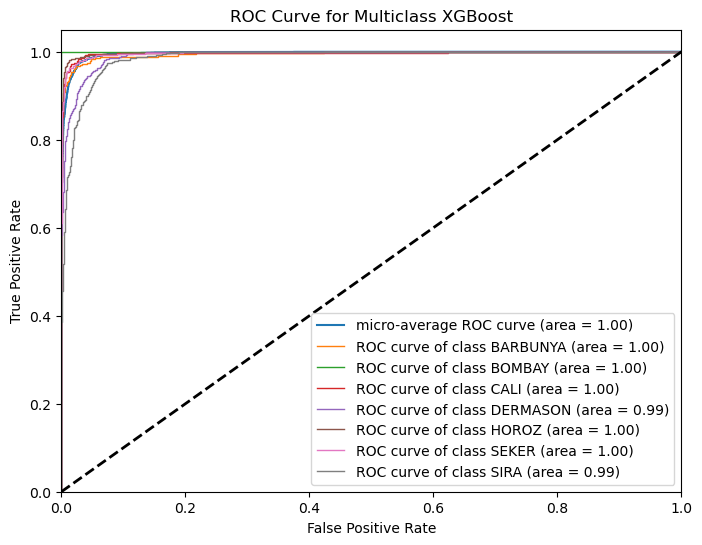

In [ ]:
#plot & calculate relative information
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt

# Define the hyperparameters
params = {
    'objective': 'multi:softmax',
    'num_class': len(classes),
    'colsample_bytree': 1.0,
    'gamma': 1,
    'learning_rate': 0.05,
    'max_depth': 8,
    'n_estimators': 300,
    'subsample': 0.8,
    'use_label_encoder': False,
    'eval_metric': 'mlogloss',
    'n_jobs': -1
}

# Train the model
model = XGBClassifier(**params)
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_all_pred = model.predict(X)

# Accuracies
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
all_acc = accuracy_score(y_int, y_all_pred)

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print("Whole Data Accuracy:", all_acc)

# Confusion Matrix and Classification Report
print("Confusion Matrix (Test):\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report (Test):\n", classification_report(y_test, y_test_pred, target_names=classes))

# ROC Curve and AUC
# Binarize the output for multiclass ROC
y_test_bin = label_binarize(y_test, classes=range(len(classes)))
y_score = model.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw=1,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))
# Calculate and print average AUC (excluding 'micro')
avg_auc = np.mean([roc_auc[j] for j in range(len(classes))])
print("Average AUC (macro, new params): {:.4f}".format(avg_auc))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass XGBoost')
plt.legend(loc="lower right")
plt.show()

Train accuracy: 0.9761186196037266
Test accuracy: 0.9265426052889324
Whole data accuracy: 0.9545220777312468

Confusion Matrix (Test):
 [[359   0  20   0   3   7   8]
 [  0 157   0   0   0   0   0]
 [ 12   0 461   0  11   2   3]
 [  0   0   0 981   0  16  67]
 [  1   0   6   6 559   0   6]
 [  1   0   0  11   0 580  16]
 [  3   0   1  80  11   9 687]]

Classification Report (Test):
               precision    recall  f1-score   support

    BARBUNYA       0.95      0.90      0.93       397
      BOMBAY       1.00      1.00      1.00       157
        CALI       0.94      0.94      0.94       489
    DERMASON       0.91      0.92      0.92      1064
       HOROZ       0.96      0.97      0.96       578
       SEKER       0.94      0.95      0.95       608
        SIRA       0.87      0.87      0.87       791

    accuracy                           0.93      4084
   macro avg       0.94      0.94      0.94      4084
weighted avg       0.93      0.93      0.93      4084

Average AUC (macr

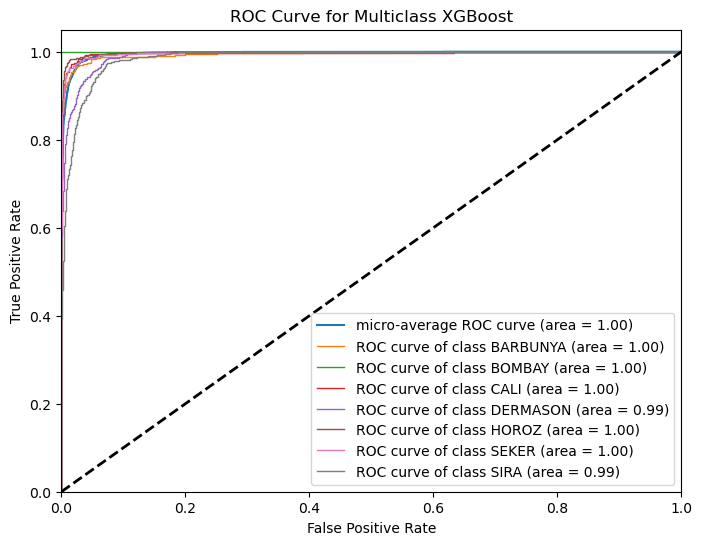

In [ ]:
#with early stopping, however, the results are exactly the same
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Use the already defined X_train, X_val, X_test, y_train, y_val, y_test

dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'multi:softmax',
    'num_class': len(classes),
    'colsample_bytree': 1.0,
    'gamma': 1,
    'eta': 0.05,
    'learning_rate': 0.05,  # eta and learning_rate are aliases, either is fine
    'max_depth': 8,
    'subsample': 0.8,
    'eval_metric': 'mlogloss'
}

num_round = 300
early_stopping_rounds = 10
evals = [(dtrain, 'train'), (dval, 'eval')]

bst = xgb.train(params, dtrain, num_round, evals=evals, early_stopping_rounds=early_stopping_rounds, verbose_eval=False)

train_pred = bst.predict(dtrain, iteration_range=(0, bst.best_iteration))
test_pred  = bst.predict(dtest, iteration_range=(0, bst.best_iteration))
all_pred   = bst.predict(xgb.DMatrix(X), iteration_range=(0, bst.best_iteration))

print("Train accuracy:", accuracy_score(y_train, train_pred))
print("Test accuracy:", accuracy_score(y_test, test_pred))
print("Whole data accuracy:", accuracy_score(y_int, all_pred))

print("\nConfusion Matrix (Test):\n", confusion_matrix(y_test, test_pred))
print("\nClassification Report (Test):\n", classification_report(y_test, test_pred, target_names=classes))

# ROC Curve and AUC
y_test_bin = label_binarize(y_test, classes=range(len(classes)))
y_score = bst.predict(xgb.DMatrix(X_test, label=y_test), output_margin=False, iteration_range=(0, bst.best_iteration+1))
if y_score.ndim == 1:  # softmax returns class indices, need probabilities for ROC
    y_score = bst.predict(xgb.DMatrix(X_test, label=y_test), output_margin=True, iteration_range=(0, bst.best_iteration+1))
    # Get class probabilities for ROC/AUC using 'multi:softprob'
    y_score = bst.predict(xgb.DMatrix(X_test), output_margin=False, iteration_range=(0, bst.best_iteration+1))
    if y_score.ndim == 1 or y_score.shape[1] != len(classes):
        # If not probabilities, fallback to XGBClassifier
        clf = XGBClassifier(
            objective='multi:softprob',
            num_class=len(classes),
            colsample_bytree=1.0,
            gamma=1,
            learning_rate=0.05,
            max_depth=8,
            subsample=0.8,
            eval_metric='mlogloss',
            n_estimators=bst.best_iteration
        )
        clf.fit(X_train, y_train)
        y_score = clf.predict_proba(X_test)
    # fallback: use XGBClassifier for proba if needed

# For multiclass, get probabilities using XGBClassifier if needed
try:
    from xgboost import XGBClassifier
    clf = XGBClassifier(**params, n_estimators=bst.best_iteration)
    clf.fit(X_train, y_train)
    y_score = clf.predict_proba(X_test)
except Exception:
    pass

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw=1,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))
# Calculate and print average AUC (excluding 'micro')
avg_auc = np.mean([roc_auc[j] for j in range(len(classes))])
print("Average AUC (macro, new params): {:.4f}".format(avg_auc))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass XGBoost')
plt.legend(loc="lower right")
plt.show()


In [ ]:
#add regularization term to xgboost to improve performance
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

data = pd.read_csv("Dry_Bean_Dataset.csv")
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
classes = np.unique(y)
y_int = np.array([np.where(classes == label)[0][0] for label in y])

print("Splitting data into train/val/test sets...")
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y_int, test_size=0.3, random_state=42, stratify=y_int)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval)

# Define parameter grid for common hyperparameters (including regularization)
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [4, 6, 8],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1],
    'reg_lambda': [1, 2],  # L2 regularization (default is 1)
    'reg_alpha': [0, 1]    # L1 regularization (default is 0)
}

xgb_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=len(classes),
    n_jobs=-1
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best hyperparameters:")
print(grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)


Splitting data into train/val/test sets...
Fitting 5 folds for each of 576 candidates, totalling 2880 fits


c:\Users\angel\.conda\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [17:23:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best hyperparameters:
{'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.8}
Best cross-validation accuracy: 0.9312428036659351


Splitting data into train/val/test sets...
Training model...
Train accuracy (new params): 0.968901718934523
Test accuracy (new params): 0.9253183153770813
Test Classification Report (new params):
               precision    recall  f1-score   support

           0       0.95      0.91      0.93       397
           1       1.00      1.00      1.00       157
           2       0.95      0.94      0.95       489
           3       0.91      0.92      0.91      1064
           4       0.96      0.97      0.96       578
           5       0.94      0.95      0.95       608
           6       0.87      0.86      0.86       791

    accuracy                           0.93      4084
   macro avg       0.94      0.94      0.94      4084
weighted avg       0.93      0.93      0.93      4084

Whole data accuracy (new params): 0.9501873484681508
Confusion Matrix (Test, new params):
 [[363   0  16   0   3   7   8]
 [  0 157   0   0   0   0   0]
 [ 14   0 460   0  10   2   3]
 [  0   0   0 977   0 

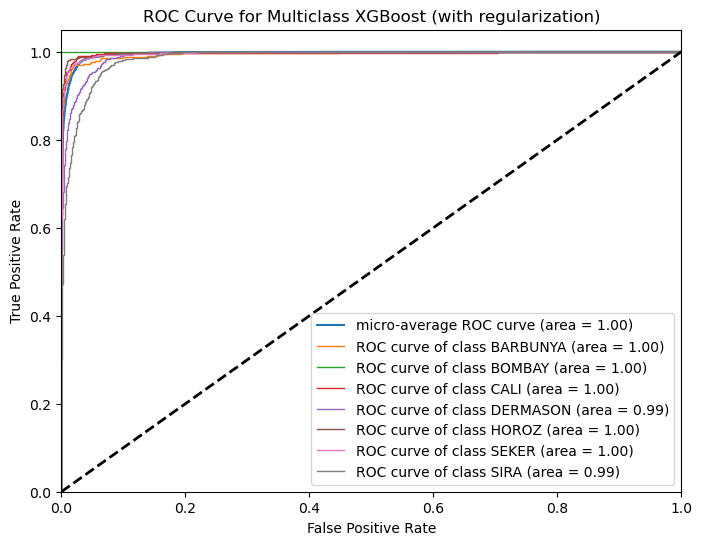

In [ ]:
#parameters trained with regularization
# no great improvement in prediction but better avoid overfitting
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize


data = pd.read_csv("Dry_Bean_Dataset.csv")
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
classes = np.unique(y)
y_int = np.array([np.where(classes == label)[0][0] for label in y])

print("Splitting data into train/val/test sets...")
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y_int, test_size=0.3, random_state=42, stratify=y_int)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval)

params_new = {'objective': 'multi:softmax','colsample_bytree': 1.0,'gamma': 1,'learning_rate': 0.2,'max_depth': 8,'reg_alpha':1,'reg_lambda':1,'subsample': 0.8,  'num_class': len(classes)}
num_round= 200



dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)
print("Training model...")
# bst_new = xgb.train(params_new, dtrain, num_boost_round=num_round, evals=[(dval, 'eval')], early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
bst_new = xgb.train(params_new, dtrain, num_boost_round=num_round)

train_pred_new = bst_new.predict(dtrain)
test_pred_new = bst_new.predict(dtest)

print("Train accuracy (new params):", accuracy_score(y_train, train_pred_new))
print("Test accuracy (new params):", accuracy_score(y_test, test_pred_new))
print("Test Classification Report (new params):\n", classification_report(y_test, test_pred_new))

import matplotlib.pyplot as plt

# Accuracy for whole dataset
all_pred_new = bst_new.predict(xgb.DMatrix(X))
all_acc_new = accuracy_score(y_int, all_pred_new)
print("Whole data accuracy (new params):", all_acc_new)

# Confusion Matrix and Classification Report for test data
print("Confusion Matrix (Test, new params):\n", confusion_matrix(y_test, test_pred_new))
print("Classification Report (Test, new params):\n", classification_report(y_test, test_pred_new, target_names=classes))

# For ROC and AUC, need class probabilities, so use 'multi:softprob'
params_prob = params_new.copy()
params_prob['objective'] = 'multi:softprob'
bst_prob = xgb.train(params_prob, dtrain, num_boost_round=num_round)
y_score_new = bst_prob.predict(dtest)

# Binarize the output for multiclass ROC
y_test_bin_new = label_binarize(y_test, classes=range(len(classes)))

fpr_new = dict()
tpr_new = dict()
roc_auc_new = dict()
for i in range(len(classes)):
    fpr_new[i], tpr_new[i], _ = roc_curve(y_test_bin_new[:, i], y_score_new[:, i])
    roc_auc_new[i] = auc(fpr_new[i], tpr_new[i])

# Compute micro-average ROC curve and ROC area
fpr_new["micro"], tpr_new["micro"], _ = roc_curve(y_test_bin_new.ravel(), y_score_new.ravel())
roc_auc_new["micro"] = auc(fpr_new["micro"], tpr_new["micro"])

plt.figure(figsize=(8, 6))
plt.plot(fpr_new["micro"], tpr_new["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_new["micro"]))
for i in range(len(classes)):
    plt.plot(fpr_new[i], tpr_new[i], lw=1,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc_new[i]))
# Calculate and print average AUC (excluding 'micro')
avg_auc = np.mean([roc_auc_new[j] for j in range(len(classes))])
print("Average AUC (macro, new params): {:.4f}".format(avg_auc))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass XGBoost (with regularization)')
plt.legend(loc="lower right")
plt.show()